# Introduction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0. Importing the libraries

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from functools import reduce

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Exploratory Data Analysis

### 1.1 Data Loading

The data is loaded from the IMDB_Dataset.csv file and the following substitution of the labels takes place.

1. '1' -> Postive
2. '0' -> Negative

In [ ]:
# Reading the dataset
imdb = pd.read_csv('/content/drive/MyDrive/MLDM Dataset/IMDB_Dataset.csv')
imdb['sentiment']= imdb['sentiment'].apply(lambda x : 1 if x=='positive' else 0)
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


### 1.2 Understanding the dataset

In [ ]:
imdb.describe()

,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


### 1.3 Visualizing the dataset

#### 1.3.1 Visualizing the frequency per sentiment

<Axes: xlabel='sentiment'>

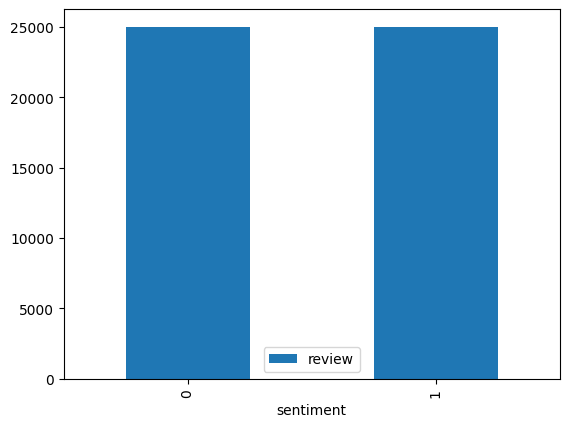

In [ ]:
imdb.groupby('sentiment').count().plot(kind='bar')

#### 1.3.2 Distribution of positive/negative words by the number of words

Positive Reviews Mean and Standard Deviation 232.84932 177.4970463517524
Negative Reviews Mean and Standard Deviation 229.46456 164.94779542332478


Text(0.5, 0.98, 'Average word length in each text')

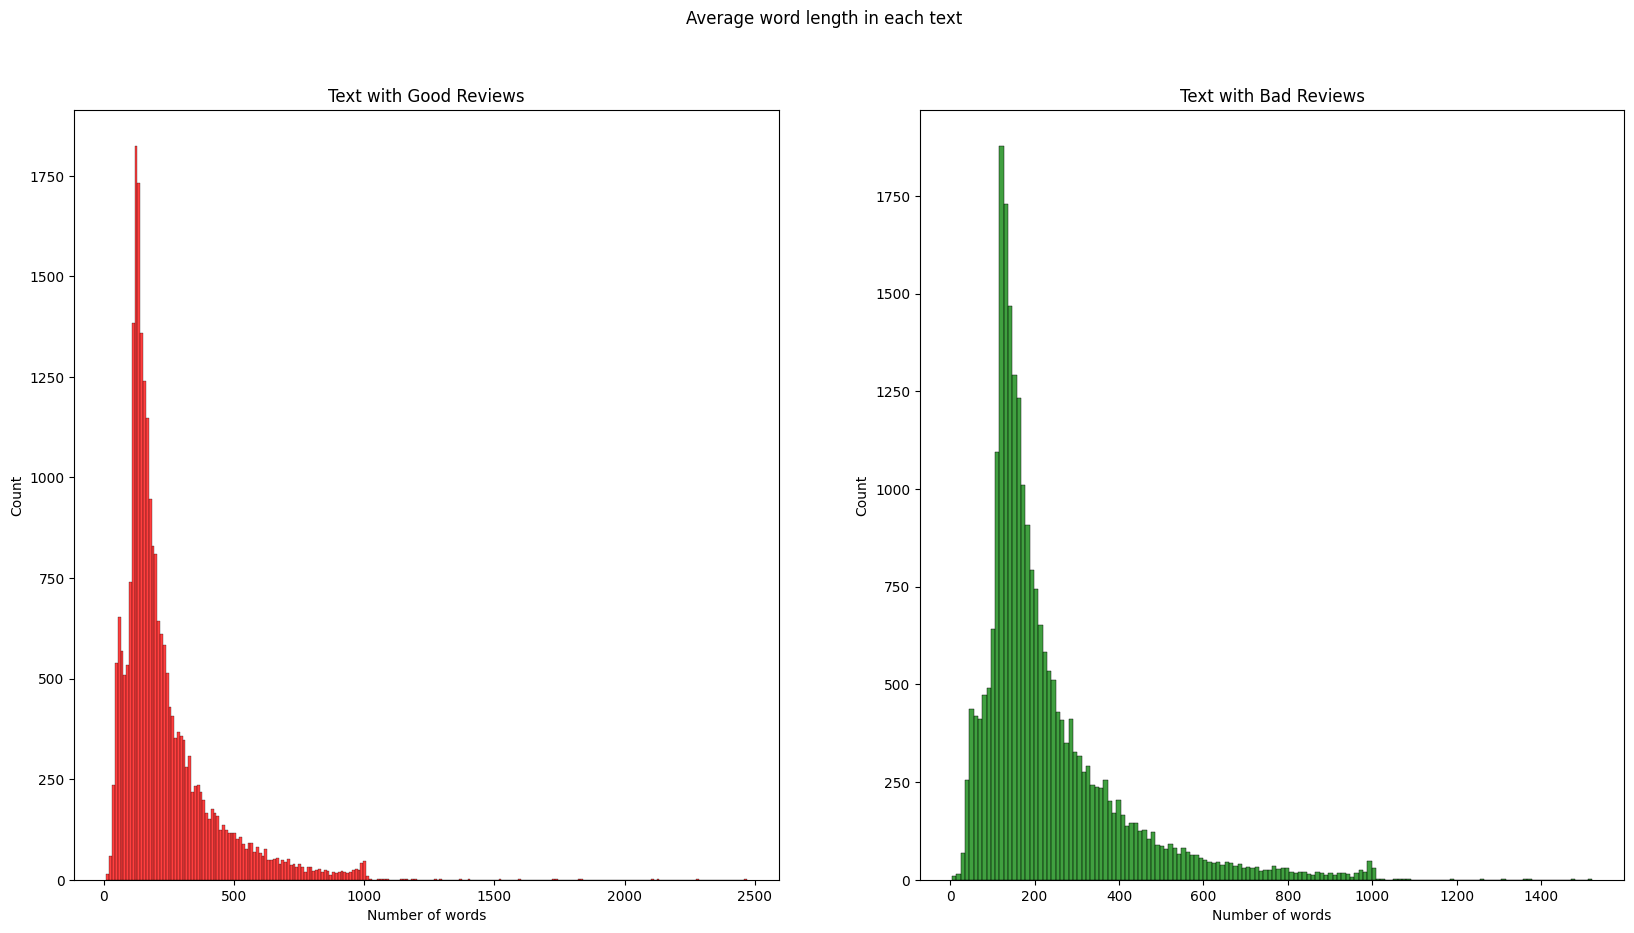

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = imdb[imdb['sentiment']==1]['review'].apply(lambda x : len(x.split()))
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Text with Good Reviews')
ax1.set_xlabel('Number of words')

print('Positive Reviews Mean and Standard Deviation', word.mean(), word.std())

word = imdb[imdb['sentiment']==0]['review'].apply(lambda x : len(x.split()))
sns.histplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Text with Bad Reviews')
ax2.set_xlabel('Number of words')
print('Negative Reviews Mean and Standard Deviation', word.mean(), word.std())

fig.suptitle('Average word length in each text')

In [ ]:
print(word.mean(), word.std())

229.46456 164.94779542332478


#### 1.3.3 Visualizing the frequency of the most common words

In [ ]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
most_common_uni = get_top_text_ngrams(imdb.review,20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

## 2. Data Preprocessing

### 2.1 Checking missing values

In [ ]:
#Missing Vlaue Checks
imdb.isna().sum()

review       0
sentiment    0
dtype: int64

### 2.2 Checking and removing duplicates

In [ ]:
#Remove Duplicates
index = imdb[imdb.duplicated() == True].index
imdb.drop(index, axis = 0, inplace = True)
imdb.reset_index(inplace=True, drop = True)

### 2.3 Text Normalization

#### 2.3.1 Lower-casing the text
#### 2.3.2 Stop word removal
#### 2.3.3 Number removal
#### 2.3.4 Remove punctuations
#### 2.3.5 Lemmatization

In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]

    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def remove_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower(text):

    text = text.split()
    text=[y.lower() for y in text]
    return " " .join(text)

def remove_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## Remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def preprocessed_text(df):
    df.review=df.review.apply(lambda review : lower(review))
    df.review=df.review.apply(lambda review : remove_stop_words(review))
    df.review=df.review.apply(lambda review : remove_numbers(review))
    df.review=df.review.apply(lambda review : remove_punctuations(review))
    df.review=df.review.apply(lambda review : remove_urls(review))
    df.review=df.review.apply(lambda review : lemmatization(review))

    return df.review

### 2.4 Splitting dataset into training and testing

In [ ]:
X = preprocessed_text(imdb)
y = imdb['sentiment']

X.head()

0    one reviewer mentioned watching oz episode hoo...
1    wonderful little production br br the filming ...
2    thought wonderful way spend time hot summer we...
3    basically there s family little boy jake think...
4    petter mattei s love time money visually stunn...
Name: review, dtype: object

In [ ]:
# Train Test Splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

### 2.5 Count Vectorizer to convert to Bag of Words (BoW)

In [ ]:
cv = CountVectorizer()
X_train_cv= cv.fit_transform(X_train)
X_train_cv.shape
X_test_cv=cv.transform(X_test)

## 3. Models

In [ ]:
performance_metrics = {}

### 3.1. Decision Tree (DT)

#### 3.1.1 Hyptertuning parameters using RandomizedSearchCV

In [ ]:
dt = DecisionTreeClassifier()

# Parameter Search Grid for RandomSearchCV
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 10)
}

random_search_dt = RandomizedSearchCV(estimator=dt, n_iter=10, param_distributions=param_dist, cv=5)

random_search_dt.fit(X_train_cv, y_train)

performance_metrics["dt_best_score"] = random_search_dt.best_score_
performance_metrics["dt_best_params"] = random_search_dt.best_params_

print("Best Parameters: ", performance_metrics["dt_best_params"])
print("Best Score: ", performance_metrics["dt_best_score"])

Best Parameters:  {'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 4}
Best Score:  0.7373250976931804


#### 3.1.2 Performance on Test Data

In [ ]:
dt = DecisionTreeClassifier(criterion = performance_metrics["dt_best_params"]["criterion"] , max_depth = performance_metrics["dt_best_params"]["max_depth"], min_samples_split = performance_metrics["dt_best_params"]["min_samples_split"], min_samples_leaf = performance_metrics["dt_best_params"]["min_samples_leaf"] )
dt.fit(X_train_cv, y_train)
y_pred = dt.predict(X_test_cv)
dt_classification_report = classification_report(y_test, y_pred, output_dict=True)

performance_metrics["dt_confusion_matrix"] = confusion_matrix(y_test, y_pred)
performance_metrics["dt_test_acc"] = dt_classification_report["accuracy"]
performance_metrics["dt_f1_score"] = dt_classification_report['weighted avg']['f1-score']
performance_metrics["dt_precision"] = dt_classification_report['weighted avg']['precision']
performance_metrics["dt_recall"] = dt_classification_report['weighted avg']['recall']

print('Test Accuracy:',performance_metrics["dt_test_acc"])
print('Weighted F1 Score:',performance_metrics["dt_f1_score"])
print('Weighted Precision Score:',performance_metrics["dt_precision"])
print('Weighted Recall Score:',performance_metrics["dt_recall"])


Test Accuracy: 0.7334879499848744
Weighted F1 Score: 0.7318229808409972
Weighted Precision Score: 0.7390004460543889
Weighted Recall Score: 0.7334879499848744


### 3.2. Random Forest (RF)

#### 3.2.1 Hyptertuning parameters using RandomizedSearchCV

In [ ]:
rf = RandomForestClassifier()

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(10, 100),
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

# Create the RandomizedSearchCV object
random_search_rf = RandomizedSearchCV(estimator=rf, n_iter=10, param_distributions=param_dist, cv=5)

# Fit the RandomizedSearchCV object to the data
random_search_rf.fit(X_train_cv, y_train)

performance_metrics["rf_best_score"] = random_search_rf.best_score_
performance_metrics["rf_best_params"] = random_search_rf.best_params_

# # Print the best parameters and best score
print("Best Parameters: ", performance_metrics["rf_best_params"])
print("Best Score: ", performance_metrics["rf_best_score"])

Best Parameters:  {'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 83}
Best Score:  0.8298247825538889


#### 3.2.2 Performance on Test Data

In [ ]:
rf = RandomForestClassifier(n_estimators = performance_metrics["rf_best_params"]["n_estimators"], criterion = performance_metrics["rf_best_params"]["criterion"] , max_depth = performance_metrics["rf_best_params"]["max_depth"], min_samples_split = performance_metrics["rf_best_params"]["min_samples_split"], min_samples_leaf = performance_metrics["rf_best_params"]["min_samples_leaf"] )
rf.fit(X_train_cv, y_train)
y_pred = rf.predict(X_test_cv)
rf_classification_report = classification_report(y_test, y_pred, output_dict=True)

performance_metrics["rf_confusion_matrix"] = confusion_matrix(y_test, y_pred)
performance_metrics["rf_test_acc"] = rf_classification_report["accuracy"]
performance_metrics["rf_f1_score"] = rf_classification_report['weighted avg']['f1-score']
performance_metrics["rf_precision"] = rf_classification_report['weighted avg']['precision']
performance_metrics["rf_recall"] = rf_classification_report['weighted avg']['recall']

print('Test Accuracy:',performance_metrics["rf_test_acc"])
print('Weighted F1 Score:',performance_metrics["rf_f1_score"])
print('Weighted Precision Score:',performance_metrics["rf_precision"])
print('Weighted Recall Score:',performance_metrics["rf_recall"])

Test Accuracy: 0.8298880709892105
Weighted F1 Score: 0.8293375270343987
Weighted Precision Score: 0.8338548226921441
Weighted Recall Score: 0.8298880709892105


### 3.3. Perceptron (PPN)

#### 3.3.1 Hyptertuning parameters using RandomizedSearchCV

In [ ]:
#Perceptron
ppn = Perceptron()

# Parameter Search Grid for RandomSearchCV
param_grid = {
    'eta0': uniform(loc=0, scale=1),
    'penalty': ['l1', 'l2'],
    'alpha': uniform(loc=0, scale=0.001)
}

random_search_ppn = RandomizedSearchCV(estimator=ppn, param_distributions=param_grid, n_iter=10, random_state=1)
random_search_ppn.fit(X_train_cv, y_train)

performance_metrics["ppn_best_score"] = random_search_ppn.best_score_
performance_metrics["ppn_best_params"] = random_search_ppn.best_params_

print("Best Parameters: ", performance_metrics["ppn_best_params"])
print("Best Score: ", performance_metrics["ppn_best_score"])

Best Parameters:  {'alpha': 9.280080864073793e-05, 'eta0': 0.518152548941889, 'penalty': 'l1'}
Best Score:  0.8458590697088113


#### 3.3.2 Performance on Test Data

In [ ]:
ppn = Perceptron(eta0 = performance_metrics["ppn_best_params"]["eta0"], penalty = performance_metrics["ppn_best_params"]["penalty"] , alpha = performance_metrics["ppn_best_params"]["alpha"])
ppn.fit(X_train_cv, y_train)
y_pred = ppn.predict(X_test_cv)
ppn_classification_report = classification_report(y_test, y_pred, output_dict=True)

performance_metrics["ppn_confusion_matrix"] = confusion_matrix(y_test, y_pred)
performance_metrics["ppn_test_acc"] = ppn_classification_report["accuracy"]
performance_metrics["ppn_f1_score"] = ppn_classification_report['weighted avg']['f1-score']
performance_metrics["ppn_precision"] = ppn_classification_report['weighted avg']['precision']
performance_metrics["ppn_recall"] = ppn_classification_report['weighted avg']['recall']

print('Test Accuracy:',performance_metrics["ppn_test_acc"])
print('Weighted F1 Score:',performance_metrics["ppn_f1_score"])
print('Weighted Precision Score:',performance_metrics["ppn_precision"])
print('Weighted Recall Score:',performance_metrics["ppn_recall"])

Test Accuracy: 0.8468286780276293
Weighted F1 Score: 0.846716859228496
Weighted Precision Score: 0.848027194771079
Weighted Recall Score: 0.8468286780276293


### 3.4. Multi-layer Perceptron (MLP)

#### 3.4.1 Hyptertuning parameters using RandomizedSearchCV

In [ ]:
mlp = MLPClassifier()

# Parameter Search Grid for RandomSearchCV
param_grid = {
    'hidden_layer_sizes': [(10,),(20,)],
    'activation': ['relu'],
    'solver': ['adam', 'sgd'],
    'max_iter' : [10, 15],
    'learning_rate': ['adaptive']
}

random_search_mlp = RandomizedSearchCV(estimator=mlp, param_distributions=param_grid, n_iter=5, random_state=1)
random_search_mlp.fit(X_train_cv, y_train)

performance_metrics["mlp_best_score"] = random_search_mlp.best_score_
performance_metrics["mlp_best_params"] = random_search_mlp.best_params_

print("Best Parameters: ", performance_metrics["mlp_best_params"])
print("Best Score: ", performance_metrics["mlp_best_score"])

Best Parameters:  {'solver': 'adam', 'max_iter': 10, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10,), 'activation': 'relu'}
Best Score:  0.8813311483675784


#### 3.4.2 Performance on Test Data

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes = performance_metrics["mlp_best_params"]["hidden_layer_sizes"], activation = performance_metrics["mlp_best_params"]["activation"] , solver = performance_metrics["mlp_best_params"]["solver"], learning_rate = performance_metrics["mlp_best_params"]["learning_rate"], max_iter = performance_metrics["mlp_best_params"]["max_iter"])
mlp.fit(X_train_cv, y_train)
y_pred = mlp.predict(X_test_cv)
mlp_classification_report = classification_report(y_test, y_pred, output_dict=True)

performance_metrics["mlp_confusion_matrix"] = confusion_matrix(y_test, y_pred)
performance_metrics["mlp_test_acc"] = mlp_classification_report["accuracy"]
performance_metrics["mlp_f1_score"] = mlp_classification_report['weighted avg']['f1-score']
performance_metrics["mlp_precision"] = mlp_classification_report['weighted avg']['precision']
performance_metrics["mlp_recall"] = mlp_classification_report['weighted avg']['recall']

print('Test Accuracy:',performance_metrics["mlp_test_acc"])
print('Weighted F1 Score:',performance_metrics["mlp_f1_score"])
print('Weighted Precision Score:',performance_metrics["mlp_precision"])
print('Weighted Recall Score:',performance_metrics["mlp_recall"])

Test Accuracy: 0.8879701522637895
Weighted F1 Score: 0.887961003927921
Weighted Precision Score: 0.8880481150494136
Weighted Recall Score: 0.8879701522637895


### 3.5. K-Nearest Neighbours (KNN)

#### 3.5.1 Hyptertuning parameters using RandomizedSearchCV

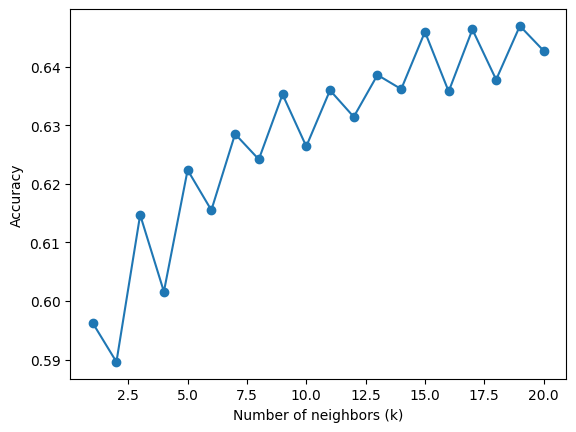

In [ ]:
# Finding the optimal numbeer of neighbours for KNN
knn_acc = []
for k in range(1, 21):
    elbow_knn = KNeighborsClassifier(n_neighbors=k)
    elbow_knn.fit(X_train_cv, y_train)
    knn_acc.append(elbow_knn.score(X_test_cv, y_test))

plt.plot(range(1, 21), knn_acc, marker='o')
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
k_neighbour = knn_acc.index(max(knn_acc))
print('The neighbour:', k_neighbour, 'is responsible for the highest accuracy:', max(knn_acc))

The neighbour: 18 is responsible for the highest accuracy: 0.6469698497529495


In [ ]:
knn = KNeighborsClassifier()

# Parameter Search Grid for RandomSearchCV
param_grid = {
    'n_neighbors': [k_neighbour],
    'p': [1, 2]
}

random_search_knn = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, n_iter=2, random_state=1)
random_search_knn.fit(X_train_cv, y_train)

performance_metrics["knn_best_score"] = random_search_knn.best_score_
performance_metrics["knn_best_params"] = random_search_knn.best_params_

print("Best Parameters: ", performance_metrics["knn_best_params"])
print("Best Score: ", performance_metrics["knn_best_score"])

Best Parameters:  {'p': 2, 'n_neighbors': 18}
Best Score:  0.6339341989159208


#### 3.5.2 Performance on Test Data

In [ ]:
knn = KNeighborsClassifier(n_neighbors = performance_metrics["knn_best_params"]["n_neighbors"], p = performance_metrics["knn_best_params"]["p"])
knn.fit(X_train_cv, y_train)
y_pred = knn.predict(X_test_cv)
knn_classification_report = classification_report(y_test, y_pred, output_dict=True)

performance_metrics["knn_confusion_matrix"] = confusion_matrix(y_test, y_pred)
performance_metrics["knn_test_acc"] = knn_classification_report["accuracy"]
performance_metrics["knn_f1_score"] = knn_classification_report['weighted avg']['f1-score']
performance_metrics["knn_precision"] = knn_classification_report['weighted avg']['precision']
performance_metrics["knn_recall"] = knn_classification_report['weighted avg']['recall']

print('Test Accuracy:',performance_metrics["knn_test_acc"])
print('Weighted F1 Score:',performance_metrics["knn_f1_score"])
print('Weighted Precision Score:',performance_metrics["knn_precision"])
print('Weighted Recall Score:',performance_metrics["knn_recall"])

Test Accuracy: 0.6377936876071393
Weighted F1 Score: 0.63102645427163
Weighted Precision Score: 0.6494143970917509
Weighted Recall Score: 0.6377936876071393


### 3.6. Support Vector Machine (SVM)

#### 3.6.1 Hyptertuning parameters using RandomizedSearchCV

In [ ]:
svm = LinearSVC()

# Parameter Search Grid for RandomSearchCV
param_grid = {
    'C': randint(1, 100),
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': randint(100, 1000),
}

random_search_svm = RandomizedSearchCV(estimator=svm, param_distributions=param_grid, n_iter=10, random_state=1)
random_search_svm.fit(X_train_cv, y_train)

performance_metrics["svm_best_score"] = random_search_svm.best_score_
performance_metrics["svm_best_params"] = random_search_svm.best_params_

print("Best Parameters: ", performance_metrics["svm_best_params"])
print("Best Score: ", performance_metrics["svm_best_score"])

Best Parameters:  {'C': 7, 'loss': 'squared_hinge', 'max_iter': 278}
Best Score:  0.8535232572797176


#### 3.6.2 Performance on Test Data

In [ ]:
svm = LinearSVC(C = performance_metrics["svm_best_params"]["C"], loss = performance_metrics["svm_best_params"]["loss"], max_iter = performance_metrics["svm_best_params"]["max_iter"])
svm.fit(X_train_cv, y_train)
y_pred = svm.predict(X_test_cv)
svm_classification_report = classification_report(y_test, y_pred, output_dict=True)

performance_metrics["svm_confusion_matrix"] = confusion_matrix(y_test, y_pred)
performance_metrics["svm_test_acc"] = svm_classification_report["accuracy"]
performance_metrics["svm_f1_score"] = svm_classification_report['weighted avg']['f1-score']
performance_metrics["svm_precision"] = svm_classification_report['weighted avg']['precision']
performance_metrics["svm_recall"] = svm_classification_report['weighted avg']['recall']

print('Test Accuracy:',performance_metrics["svm_test_acc"])
print('Weighted F1 Score:',performance_metrics["svm_f1_score"])
print('Weighted Precision Score:',performance_metrics["svm_precision"])
print('Weighted Recall Score:',performance_metrics["svm_recall"])

Test Accuracy: 0.8598366441464153
Weighted F1 Score: 0.8598361310661582
Weighted Precision Score: 0.8598367371004011
Weighted Recall Score: 0.8598366441464153


### 4. Results and Comparison

#### 4.1 ROC Curve

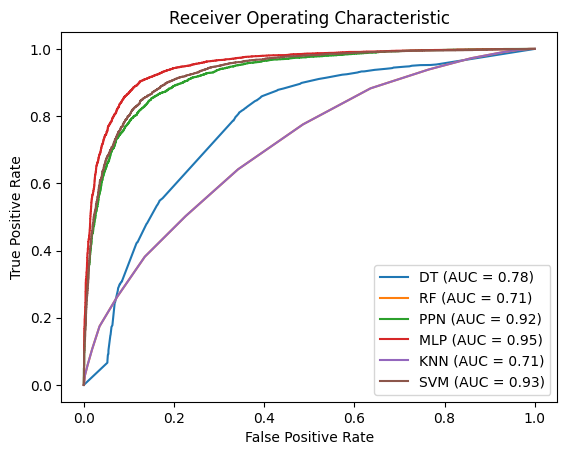

In [ ]:
# Predict probabilities for test data using both models
y_dt_prob = dt.predict_proba(X_test_cv)[:,1]
y_rf_prob = knn.predict_proba(X_test_cv)[:,1]
y_ppn_prob = ppn.decision_function(X_test_cv)
y_mlp_prob = mlp.predict_proba(X_test_cv)[:,1]
y_knn_prob = knn.predict_proba(X_test_cv)[:,1]
y_svm_prob = svm.decision_function(X_test_cv)

# Calculate the FPR and TPR for different probability thresholds for each model
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_dt_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_rf_prob)
fpr_ppn, tpr_ppn, _ = roc_curve(y_test, y_ppn_prob)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_mlp_prob)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_knn_prob)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_svm_prob)

# Calculate the AUC scores for each model
auc_dt = auc(fpr_dt, tpr_dt)
auc_rf = auc(fpr_rf, tpr_rf)
auc_ppn = auc(fpr_ppn, tpr_ppn)
auc_mlp = auc(fpr_mlp, tpr_mlp)
auc_knn = auc(fpr_knn, tpr_knn)
auc_svm = auc(fpr_svm, tpr_svm)

# Plot the ROC curves for both models
plt.plot(fpr_dt, tpr_dt, label='DT (AUC = %0.2f)' % auc_dt)
plt.plot(fpr_rf, tpr_rf, label='RF (AUC = %0.2f)' % auc_rf)
plt.plot(fpr_ppn, tpr_ppn, label='PPN (AUC = %0.2f)' % auc_ppn)
plt.plot(fpr_mlp, tpr_mlp, label='MLP (AUC = %0.2f)' % auc_mlp)
plt.plot(fpr_knn, tpr_knn, label='KNN (AUC = %0.2f)' % auc_knn)
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = %0.2f)' % auc_svm)

# # Set the title and axis labels
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# # Add a legend and show the plot
plt.legend()
plt.show()

#### 4.2 Comparing Cross Validated Accuracy and Testing Accuracy

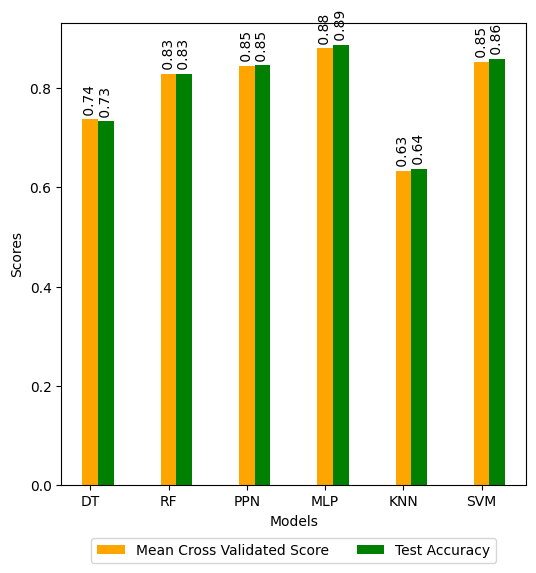

In [ ]:
x = np.arange(1, 7)
y1 = [performance_metrics["dt_best_score"], performance_metrics["rf_best_score"], performance_metrics["ppn_best_score"],
      performance_metrics["mlp_best_score"], performance_metrics["knn_best_score"], performance_metrics["svm_best_score"]]

y2 = [performance_metrics["dt_test_acc"], performance_metrics["rf_test_acc"], performance_metrics["ppn_test_acc"],
      performance_metrics["mlp_test_acc"], performance_metrics["knn_test_acc"], performance_metrics["svm_test_acc"]]

width = 0.2

plt.figure(figsize=(6, 6))

# Plot Grouped-Bar Chart for comparison
plt.bar(x, y1, width, color='orange')
plt.bar(x+0.2, y2, width, color='green')

# Add labels to the bars
for i, (a, b) in enumerate(zip(y1, y2)):
    plt.annotate(" " +str(round(a, 2)), xy=(x[i], a), ha='center', va='bottom', color='black', rotation='vertical')
    plt.annotate(" " +str(round(b, 2)), xy=(x[i] + 0.2, b), ha='center', va='bottom', color='black', rotation='vertical')

plt.xticks(x, ['DT', 'RF', 'PPN', 'MLP', 'KNN', 'SVM'])
plt.xlabel("Models")
plt.ylabel("Scores")
plt.legend(["Mean Cross Validated Score", "Test Accuracy"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.show()

#### 4.3 Comparing F1 Score, Recall and Precision on Test Data

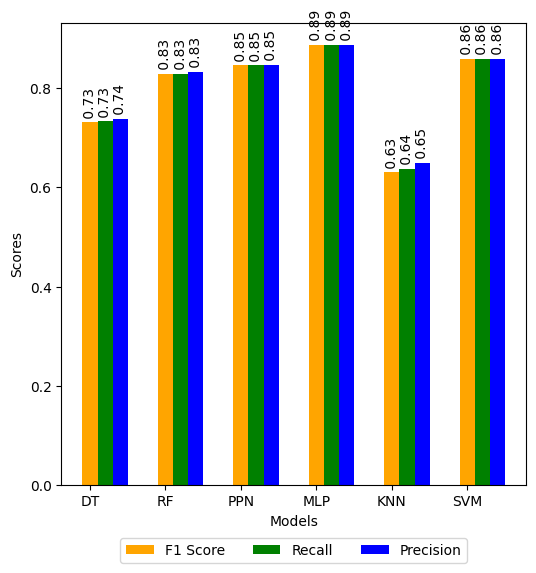

In [ ]:
# Sample data
x = np.arange(1, 7)
y3 = [performance_metrics["dt_f1_score"], performance_metrics["rf_f1_score"], performance_metrics["ppn_f1_score"],
      performance_metrics["mlp_f1_score"], performance_metrics["knn_f1_score"], performance_metrics["svm_f1_score"]]

y4 = [performance_metrics["dt_recall"], performance_metrics["rf_recall"], performance_metrics["ppn_recall"],
      performance_metrics["mlp_recall"], performance_metrics["knn_recall"], performance_metrics["svm_recall"]]

y5 = [performance_metrics["dt_precision"], performance_metrics["rf_precision"], performance_metrics["ppn_precision"],
      performance_metrics["mlp_precision"], performance_metrics["knn_precision"], performance_metrics["svm_precision"]]

width = 0.2

plt.figure(figsize=(6, 6))

# Plot Grouped-Bar Chart for comparison
plt.bar(x, y3, width, color='orange')
plt.bar(x + 0.2, y4, width, color='green')
plt.bar(x + 0.4, y5, width, color='blue')

# Add labels to the bars
for i, (a, b, c) in enumerate(zip(y3, y4, y5)):
    plt.annotate(" " +str(round(a, 2)), xy=(x[i], a), ha='center', va='bottom', color='black', rotation='vertical')
    plt.annotate(" " +str(round(b, 2)), xy=(x[i] + 0.2, b), ha='center', va='bottom', color='black', rotation='vertical')
    plt.annotate(" " +str(round(c, 2)), xy=(x[i] + 0.4, c), ha='center', va='bottom', color='black', rotation='vertical')

plt.xticks(x, ['DT', 'RF', 'PPN', 'MLP', 'KNN', 'SVM'])
plt.xlabel("Models")
plt.ylabel("Scores")
plt.legend(["F1 Score", "Recall", "Precision"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()


#### 4.4 Summary of Performance Metrics for Models

In [ ]:
data = {
    'Models' : ['Decision Tree', 'Random Forest', 'Perceptron', 'Multi-layer Perceptron', 'K Nearest Neighbours', 'Support Vector Machine'],
    'Mean Cross Val Score': y1,
    'Test Accuracy': y2,
    'F1 Score': y3,
    'Recall' : y4,
    'Precision': y5,
}

summary_results = pd.DataFrame(data)
summary_results.head()

,Models,Mean Cross Val Score,Test Accuracy,F1 Score,Recall,Precision
0,Decision Tree,0.737325,0.733488,0.731823,0.733488,0.739000
1,Random Forest,0.829825,0.829888,0.829338,0.829888,0.833855
2,Perceptron,0.845859,0.846829,0.846717,0.846829,0.848027
3,Multi-layer Perceptron,0.881331,0.887970,0.887961,0.887970,0.888048
4,K Nearest Neighbours,0.633934,0.637794,0.631026,0.637794,0.649414
